In [1]:
import numpy as np
import fipy as fp

import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
from matplotlib.animation import FuncAnimation
#from matplotlib import animation, rc
from IPython.display import HTML

def update_progress(process,progress):
    import sys
    barLength = 100 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\r"+process+": [{0}] {1:.0f}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()
    
print(fp.DefaultSolver)

<class 'fipy.solvers.petsc.linearGMRESSolver.LinearGMRESSolver'>


In [113]:
Te = 4000
n0 = 1e8
n_hot = 5e19
import scipy.constants as sc
LL = 12
#Braginskiy Eq. 2.5e
tee = 12. * np.pi**1.5 /2**0.5 * sc.m_e**0.5 * sc.epsilon_0**2 * (sc.e * Te)**1.5 / (sc.e**4 * n_hot * LL)

SQ  = 3. * n0 * Te * 1.6e-19 / tee 
tau = 1./ (3. * n0) * SQ # Dnestrovskiy Eq. 65

n_ana   = lambda x,t: n0*np.sqrt(3.*sc.m_p/(8.*t**3*np.pi*tau))*np.exp(-3.*sc.m_p*x**2/(8.*t**3*tau))

Setup for the shallow water equations solution. $L_x$ is in the Debye lengths, $dt$ is in the reciprocal ion plasma friquency

In [161]:
Lx = 40.; dt = 0.1e-6; steps = 220

Our mesh will span $[-L_x/2;L_x/2]$

In [162]:
t = 10.e-6

In [163]:
#base = 20; N =100
#nonUniform_x = Lx/(base-1.)*(np.logspace(0.,1.,N+1,base=base,endpoint=True)-1.)
#mesh  = fp.Grid1D(dx=np.diff(nonUniform_x))

mesh = fp.Grid1D(nx=1000, Lx=Lx) - 0 * Lx/2.; 
x = mesh.x

Shallow water equations for expanding plasma take the form
\begin{equation}
\frac{\partial n}{dt} + \frac{1}{dx} (nv) = 0,
\end{equation}
\begin{equation}
\frac{\partial v}{dt} + v\frac{\partial v}{dx} = - T(t)\frac{\partial \ln(n)}{dx}
\end{equation}

In [193]:
n = fp.CellVariable(mesh=mesh, hasOld = True)
v = fp.CellVariable(mesh=mesh, hasOld = True)
v_face = fp.FaceVariable(mesh=mesh, rank=0, value=0.)

T = fp.Variable(value = tau*t)

In [194]:
#cont_eq = (fp.TransientTerm(var=n) + fp.ConvectionTerm(coeff=v_face*[[1.0]], var=n) == 0)
#moti_eq = (fp.TransientTerm(var=v) + fp.ConvectionTerm(coeff=v_face*[[0.5]], var=v) + T / sc.m_p * n.grad[0]/n == 0) # T * (fp.numerix.log(n.faceValue)).divergence #

cont_eq = (fp.TransientTerm(var=n) + fp.ConvectionTerm(coeff=v_face*[[1.]], var=n) == 0)
moti_eq = (fp.TransientTerm(var=v) + fp.ConvectionTerm(coeff=v_face*[[1.]], var=v) - \
                    fp.ImplicitSourceTerm(coeff=v_face.divergence, var=v) + T / sc.m_p * n.grad[0]/n == 0)

eqn = cont_eq & moti_eq

Rougth boundary condition for $v$.

Next test is gaussian pellet. Now we start from $T=0$ in Eq. (2), so it needs more time to expand.

In [195]:
n.faceGrad.constrain(0.  , where=mesh.facesLeft)
n.faceGrad.constrain(0.  , where=mesh.facesRight)
v.constrain(0.           , where=mesh.facesLeft)
v.faceGrad.constrain(0.           , where=mesh.facesRight)

v.setValue(1.5*x/t)
n.setValue(n0*np.sqrt(3.*sc.m_p/(8.*t**3*np.pi*tau))*fp.numerix.exp(-3.*sc.m_p*x**2/(8.*t**3*tau))+n0*1e-20)

Initial conditons

In [196]:
n.updateOld()
v.updateOld()

v_face[:] = v.arithmeticFaceValue
v_face[..., mesh.exteriorFaces.value] = 0.

#First relaxation with tiny timestep
res = 1e100
for i in range(20):
    res = eqn.sweep(dt=dt)
    print(res)
t += dt

800946046367.6616
199345906755.52338
282178477.1154484
2684340.1791034094
34464.7483604537
446.3561294316631
5.8092923415522195
0.10674437212745432
0.06795255983578093
0.06835800624117558
0.06837369950726656
0.06837369950726656
0.06837369950726656
0.06837369950726656
0.06837369950726656
0.06837369950726656
0.06837369950726656
0.06837369950726656
0.06837369950726656
0.06837369950726656


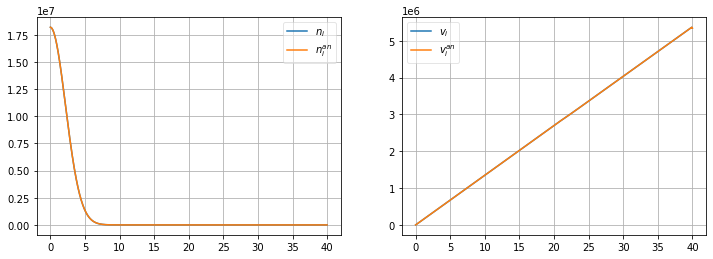

In [197]:
fig = plt.figure(figsize=(12,4))
ax1 =  fig.add_subplot(121)
ax2 =  fig.add_subplot(122)

x_plot = np.array(mesh.x)
p_n,      = ax1.plot(x_plot, n.value, '-', label = '$n_i$')
p_v,      = ax2.plot(x_plot, v.value, '-',label = '$v_i$')
a_n,      = ax1.plot(x_plot, n.value, '-', label = '$n_i^{an}$')
a_v,      = ax2.plot(x_plot, v.value, '-',label = '$v_i^{an}$')

ax1.grid()
ax2.grid()
ax1.legend(framealpha=0.5)
ax2.legend(framealpha=0.5)
plt.show()

In [198]:
def update2(i):
    #print 1.*i
    update_progress('Progress',1.*i/steps)
    global t,tau,T
    n.updateOld()
    v.updateOld()
    T.setValue(t*tau)
    res = 1e100
    isweep = 0
    while res > 1.:
        isweep+=1
        v_face[:] = v.arithmeticFaceValue
        v_face[..., mesh.exteriorFaces.value] = 0.
        res = eqn.sweep(dt=dt)    
        #print(res)
        if isweep > 100:
            print(i,'No converge',res)
            break
    t = t + dt
    p_n.set_ydata(n.value)
    p_v.set_ydata(v.value)
    a_n.set_ydata(n_ana(x.value,t))
    a_v.set_ydata(1.5*x/t)
    ax1.set_ylim((0,max(n.value)*1.2))
    ax2.set_ylim((0,max(n_ana(x.value,t))))

In [199]:
animation2 = FuncAnimation(fig, update2, frames=steps, repeat=False)

In [ ]:
animation2

Progress: [########################################################################################------------] 88% 

In [112]:
res

0.0293326021655493